In [559]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.models import Sequential
import tensorflow_datasets as tfds
from tensorflow.keras import datasets, layers, models

In [560]:
import os 
from os import listdir
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import PIL
from PIL import Image

**pre-processing the data**

In [856]:
(img_h, img_w) = (180,180)

In [857]:
def loadImages(path, label):
    arr = np.ndarray([1,img_h, img_w ,3])
    imagesList = listdir(path)
    for image in imagesList:
        img = Image.open(path + image)
        img = asarray(img)
        img = cv2.resize(img, (img_h, img_w), interpolation=cv2.INTER_CUBIC)
        img = np.expand_dims(img, axis=0)
        arr = np.append(arr, img, axis = 0)
    arr = arr[1::] 
    return arr

In [858]:
labels = np.array([listdir('./boats')[0::]])

In [859]:
labels_map = {'buoy':0, 'cruise ship':1, 'ferry boat':2, 'freight boat':3, 'gondola':4,
       'inflatable boat':5, 'kayak':6, 'paper boat':7, 'sailboat':8}

In [865]:
data_images = {}
data_labels = {}
for label in labels[0]:
    path = './boats/{}/'.format(label)
    data_images["images_%s" %label] = loadImages(path, label)
    data_labels["label_%s" %label] = np.array([labels_map['%s' %label] 
                                               for x in 
                                           range(data_images["images_%s" %label].shape[0])])
    data_labels["label_%s" %label] = np.expand_dims(data_labels["label_%s" %label],
                                                    axis=1)
    

In [866]:
label = np.concatenate(list(data_labels["label_%s" %label] for label in labels[0])
                        , axis=0)

In [867]:
data = np.concatenate(list(data_images["images_%s" %label] for label in labels[0]), axis=0)

In [868]:
label.shape

(1460, 1)

In [869]:
data.shape

(1460, 180, 180, 3)

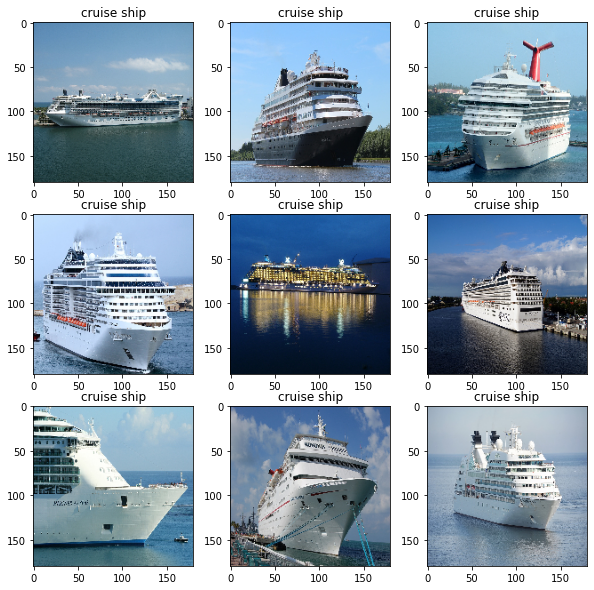

In [871]:
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(data[i+120].astype("uint8"))
    plt.title(labels_map_vers[int(label[i+120])])

In [872]:
training_idx = np.random.randint(data.shape[0], size=int(np.ceil(data.shape[0]*0.8)))
test_idx = np.random.randint(data.shape[0], size=int(np.floor(data.shape[0]*0.2)))

In [873]:
training_data, training_labels = data[training_idx,:], label[training_idx,:]

In [874]:
test_data, test_labels = data[test_idx,:], label[test_idx,:]

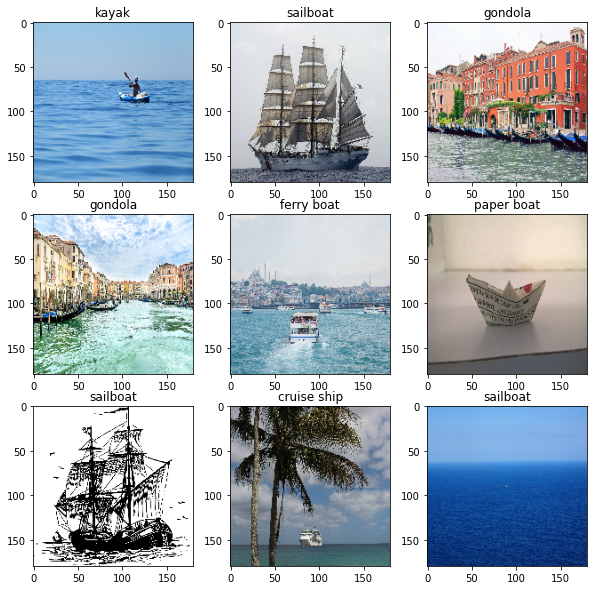

In [875]:
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(training_data[i+20].astype("uint8"))
    plt.title(labels_map_vers[int(training_labels[i+20])])

In [876]:
labels_map_vers = {0:'buoy', 1:'cruise ship', 2:'ferry boat', 3:'freight boat', 4:'gondola',
       5:'inflatable boat', 6:'kayak', 7:'paper boat', 8:'sailboat'}

**the model**

In [877]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [893]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical", 
                                                 input_shape=(img_h,
                                                               img_w,  
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

In [894]:
num_classes = 9

model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [895]:
model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_15 (Sequential)   (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_10 (Rescaling)     (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 45, 45, 64)      

In [896]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [897]:
loss0, accuracy0 = model.evaluate(training_data,
                    training_labels)

37/37 [==============================] - 3s 88ms/step - loss: 2.1900 - accuracy: 0.1538


In [898]:
ephocs = 15

In [899]:
history = model.fit(training_data,
                    training_labels,
                    epochs=ephocs, 
                    validation_data=(test_data, test_labels))

Epoch 1/15
37/37 [==============================] - 17s 458ms/step - loss: 1.9823 - accuracy: 0.2979 - val_loss: 3.0011 - val_accuracy: 0.0000e+00
Epoch 2/15
37/37 [==============================] - 20s 531ms/step - loss: 1.7431 - accuracy: 0.3604 - val_loss: 2.7467 - val_accuracy: 0.0000e+00
Epoch 3/15
37/37 [==============================] - 21s 557ms/step - loss: 1.6316 - accuracy: 0.4204 - val_loss: 3.2378 - val_accuracy: 0.0719
Epoch 4/15
37/37 [==============================] - 21s 555ms/step - loss: 1.5352 - accuracy: 0.4726 - val_loss: 3.2364 - val_accuracy: 0.0993
Epoch 5/15
37/37 [==============================] - 24s 635ms/step - loss: 1.4403 - accuracy: 0.5094 - val_loss: 2.7382 - val_accuracy: 0.2158
Epoch 6/15
37/37 [==============================] - 21s 555ms/step - loss: 1.4250 - accuracy: 0.4957 - val_loss: 2.6016 - val_accuracy: 0.1541
Epoch 7/15
37/37 [==============================] - 21s 573ms/step - loss: 1.3088 - accuracy: 0.5599 - val_loss: 2.9666 - val_accuracy

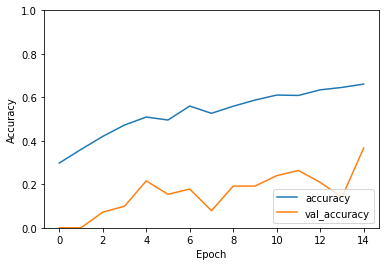

In [900]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')